# Experiment 0530 - how good are GPT models in Fermi Estimation (GPT4)

In [ ]:
# dependency
%pip install python-dotenv
%pip install openai
%pip install pandas

In [1]:
import os
from dotenv import load_dotenv, find_dotenv # load keys from .env file
import openai # use OpenAI API
import random
import json
import pandas as pd
import numpy as np
import datetime

_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key  = os.getenv('OPENAI_API_KEY')

In [2]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens=600, # this is the maximum number of tokens to generate
    )
    print(">>>>RESPONSE>>>>")
    print(str(response.choices[0].message["content"]))
    print("<<<<END<<<<")
    return response.choices[0].message["content"]

def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=20
    )
    return response.choices[0].message["content"]

In [ ]:
# Uncomment and Run this code block to get an example output

# prompt_example= f"""What is Fermi Estimation and how does it work?"""
# response = get_completion(prompt_example)

## Prompt Design (3rd iteration)

In [9]:
# We selected prompt 1 ,2 , 4 for our experiment
# prompt 1 - competence prompt: (simple instruction + 0-shot)
def prompt_1(question):
    return f"""\
TASK: A curious learner will ask you a question:
You know the answer in the order of magnitude. You will teach the learner, step by step, \
how they can work out an estimated answer themselves. You are allowed to make assumptions. Answer in the order of magnitude (10^x) and report value of x in ANSWER. \

QUESTION: {question}
REASON: [your reason]
ESTIMATED VALUE: 10^[your answer]
"""

# prompt 2 - simple context + CoT instruction + 1-shot example)
def prompt_2(question):
    return f"""\
TASK: You are an AI assistant helping people answer solve problems using Fermi estimation. \
Fermi estimation is a problem-solving technique that involves making rough estimates and approximations to arrive at a reasonable answer.
Here's how you might approach it:
QUESTION: How many piano tuners are there in Chicago? (answer with unit of 'piano tuners')
REASON: 1. First, estimate the population of Chicago. The population of Chicago was about 2.7 million. \
2. Assume an average household size. In the U.S., this is typically around 2.5 people per household.\ 
Therefore, there are approximately 1.08 million households in Chicago (2.7 million people / 2.5 people per household). \
3. Next, you would estimate the fraction of households with a piano. We can make a conservative estimate and say 1 in every 100 households owns a piano. \
So, there are about 10,800 pianos in Chicago (1.08 million households / 100). \
4. Now, estimate how often a piano needs to be tuned. Professional piano tuners usually recommend tuning a piano at least once or twice a year. \
Let's assume once a year for simplicity, so 10,800 piano tunings are required per year.\
5. Finally, estimate the number of tunings a single piano tuner can perform in a year. If a tuner works 5 days a week and 50 weeks a year, that's 250 workdays. \
Let's say a tuner can handle 2 tunings a day, which means one tuner can handle about 500 tunings in a year.
Now you can estimate the number of piano tuners in Chicago by dividing the total number of annual tunings by the number of tunings per tuner. \
So, there are approximately 21.6 piano tuners (10,800 tunings / 500 tunings per tuner).\
ESTIMATED VALUE: x = 10^2 piano tuners

QUESTION: {question}
REASON: [your embedded reason]
ESTIMATED VALUE: x = 10^[your answer]
"""

# prompt 4 - with more classic examples (simple context and examples generated by LLM + 3-shot)
def prompt_4(question):
    return f"""\
You are providing a Fermi estimation for a given question. Show your assumptions, calculations, and the final estimated value in the order of magnitude (expressed in 10^n). Follow the examples to answer an estimation question after  ------.
Example 1:
**Please provide a Fermi estimation for this question: How many soccer balls would fit inside the Eiffel Tower?**
RESPONSE:
- **Assumptions**: Assume the Eiffel Tower is a cylinder with a height of 300m and base diameter of 100m. Assume a standard soccer ball has a diameter of 22cm.
- **Calculations**: Calculate the volume of the Eiffel Tower using the formula for a cylinder, πr²h, and divide by the volume of a soccer ball, 4/3*πr³. Compensate for the packing efficiency of spheres in a space, typically around 0.74.
- **Estimated Value**: The estimated value is in the order of magnitude of 10^7 soccer balls.

Example 2:

**Please provide a Fermi estimation for this question: How many grains of sand are there on a typical beach?**
RESPONSE:
- **Assumptions**: Assume a typical beach is 1km long, 100m wide, and the sand is 1m deep. Assume a grain of sand is about 0.5mm in diameter.
- **Calculations**: Calculate the volume of the beach, multiply by the density of sand, and then divide by the volume of a grain of sand. Again, compensate for the packing efficiency of spheres, typically around 0.64.
- **Estimated Value**: The estimated value is in the order of magnitude of 10^15 grains of sand.

Example 3:

**Please provide a Fermi estimation for this question: How many piano tuners are there in New York City?**
RESPONSE:
- **Assumptions**: Assume the population of New York City is 8 million. Assume that on average, one in 800 people own a piano. Assume a piano needs to be tuned once a year, and one tuner can tune a piano in 2 hours and works 2000 hours a year.
- **Calculations**: Calculate the total number of pianos in New York City by multiplying the population by the ratio of piano owners. Then, calculate how many pianos a single tuner can tune in a year. Divide the total number of pianos by this to get the number of tuners.
- **Estimated Value**: The estimated value is in the order of magnitude of 10^2 piano tuners.
------

**Please provide a Fermi estimation for this question: {question}**
"""

## Data collection / query the model

In [26]:
# using the filtered output from Allen_realFP
data = pd.read_csv(f"../src/filter_output_true_20230529-171055.csv")
data = data.drop("Unit", axis=1)

seed = 123 # [123, 1234]
# we will sample 50 questions from the filtered output
sampled_data = data.sample(n=100, random_state=12345)
print(sampled_data.head())
# print(df.iloc[353, 2])
# print(df.at[353, 'Unit'])


# sampled_data.apply(lambda row: inference(row), axis=1)


                                              Question Answer   
430  How many times could you say the alphabet in 2...      4  \
636  How many people are airborne over the US at an...      4   
99   What proportion of the world's grain supply is...   -1.0   
119  If the entire world population started mining ...    5.0   
370       How many peas would you need to fill a bath?      5   

                                       filter_response   
430           E1. True\nE2. Count of numbers\nE3. N.A.  \
636           E1. True\nE2. Count of numbers\nE3. N.A.   
99                  E1. True\nE2. Ratio\nE3. Not Given   
119  E1. True\nE2. Physical quantity with unit (tim...   
370           E1. True\nE2. Count of numbers\nE3. N.A.   

                                           filter_dict    E1   
430  {'E1': 'True', 'E2': 'Count of numbers', 'E3':...  True  \
636  {'E1': 'True', 'E2': 'Count of numbers', 'E3':...  True   
99    {'E1': 'True', 'E2': 'Ratio', 'E3': 'Not Given'}  True   
119 

The average difference for constant -20 is:  0.006666666666666667
The average difference for constant -19 is:  0.013333333333333334
The average difference for constant -18 is:  0.013333333333333334
The average difference for constant -17 is:  0.013333333333333334
The average difference for constant -16 is:  0.006666666666666667
The average difference for constant -15 is:  0.0033333333333333335
The average difference for constant -14 is:  0.0
The average difference for constant -13 is:  0.0
The average difference for constant -12 is:  0.0
The average difference for constant -11 is:  0.0
The average difference for constant -10 is:  0.0
The average difference for constant -9 is:  0.0
The average difference for constant -8 is:  0.0
The average difference for constant -7 is:  0.0
The average difference for constant -6 is:  0.0033333333333333335
The average difference for constant -5 is:  0.006666666666666667
The average difference for constant -4 is:  0.023333333333333338
The average differ

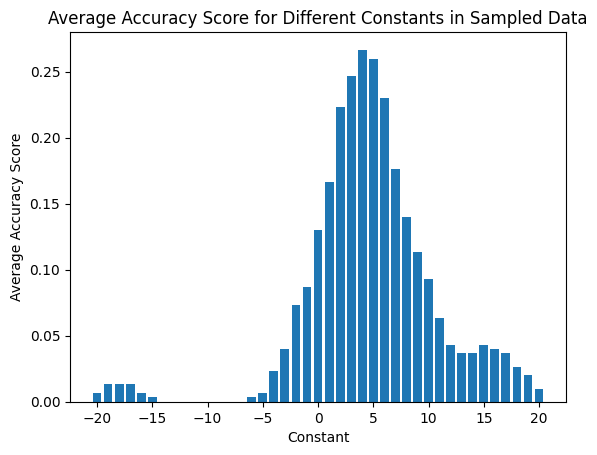

The average difference for constant -20 is:  0.003694581280788177
The average difference for constant -19 is:  0.003694581280788177
The average difference for constant -18 is:  0.0032840722495894913
The average difference for constant -17 is:  0.0032840722495894913
The average difference for constant -16 is:  0.002873563218390805
The average difference for constant -15 is:  0.004105090311986864
The average difference for constant -14 is:  0.004515599343185551
The average difference for constant -13 is:  0.005336617405582923
The average difference for constant -12 is:  0.003694581280788177
The average difference for constant -11 is:  0.0032840722495894913
The average difference for constant -10 is:  0.003694581280788177
The average difference for constant -9 is:  0.005336617405582923
The average difference for constant -8 is:  0.006157635467980296
The average difference for constant -7 is:  0.0049261083743842365
The average difference for constant -6 is:  0.005336617405582923
The averag

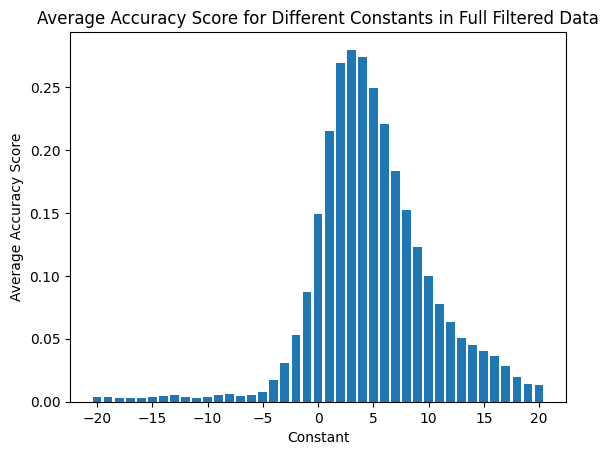

In [33]:
# check answer against a constant (e,g, 10^2)
# Define your constant
x = 3

# Define your self-defined function
def calculate_difference(answer, x):
    try:
        return calculate_performance_score(float(answer) - x)
    except ValueError:
        return None

def calculate_performance_score(difference):
    try:
        return max(0, 1 - abs(difference) / 3)
    except ValueError:
        return None

# Apply the function to the 'answer' column
# print(copy[["Answer","Score"]])

# sweep through (10^-10 to 10^10) to obtain the best guess distribution

def sweep_score(df, min:int =-20, max:int = 20):
    sweep_score = []
    for x in range(min, max+1):
        copy = df.copy()
        new_col = f"Score_constant_{x}"
        copy[new_col] = df["Answer"].apply(lambda answer: calculate_difference(answer, x))
        average_PI = copy[new_col].mean()
        print(f"The average difference for constant {x} is: ", average_PI)
        sweep_score.append(average_PI)
    return sweep_score

sweep_score_for_sampled_data = sweep_score(sampled_data)
# plot the sweep score in bar chart
import matplotlib.pyplot as plt
plt.bar(range(-20, 21), sweep_score_for_sampled_data)
plt.xlabel("Constant")
plt.ylabel("Average Accuracy Score")
plt.title("Average Accuracy Score for Different Constants in Sampled Data")
plt.show()

sweep_score_for_full_data = sweep_score(data)
# plot the sweep score in bar chart
plt.bar(range(-20, 21), sweep_score_for_full_data)
plt.xlabel("Constant")
plt.ylabel("Average Accuracy Score")
plt.title("Average Accuracy Score for Different Constants in Full Filtered Data")
plt.show()



### Experiment with sampled data

In [13]:
# Get the current date and time
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

prompt_list = [prompt_1, prompt_2, prompt_4]

def inference(row, prompt, model='gpt-3.5-turbo', num_trials=3):
    # if row or prompt are not defined or empty, return None
    question = row['Question']
    if not question or not prompt:
        return None
    for i in range(num_trials): # default max 3 trials
        try:
            # Assuming that get_completion function returns the answer
            return get_completion(prompt(question), model=model)
        except Exception as e:
            print(f"Encountered an error at question {row.name} in trial {i+1}: {e}")
            # If it's the last trial, don't try again
            if i == num_trials - 1:
                return "ERROR"
            else:
                print("Retrying...")
            # Add 'ERROR' to the results dictionary 

result_data = sampled_data.copy()

import time
time_taken_for_each_round = []
# iterate through each question in sampled question list with prompt 1-4
prompt_list_index = [1]
for index in range(len(prompt_list)):
    starting_time = time.time()
    experiment_prompt = prompt_list[index]
    prompt_index = prompt_list_index[index]
    result_data[f"Prompt_{prompt_index}_result"] = sampled_data.apply(lambda row: inference(row, experiment_prompt, model="gpt-4"), axis=1)
    time_taken_for_each_round.append(time.time() - starting_time)
    print(f"COMPLELETD PROMPT {prompt_index}")
    # save data to csv with timestamp for post analysis
    csv_filename = f"est_out_prompt_{prompt_index}_{timestamp}.csv"
    result_data.to_csv(csv_filename, index=False)

# print out time taken for each round
for i in range(len(time_taken_for_each_round)):
    print(f"round {i+1} time taken: {time_taken_for_each_round[i]} seconds")

print(f"total time taken: {sum(time_taken_for_each_round)} seconds")


>>>>RESPONSE>>>>
To estimate how many times you could say the alphabet in 24 hours, we can follow these steps:

Step 1: Estimate the time it takes to say the alphabet once
Let's assume it takes about 5 seconds to say the alphabet once. This is a rough estimate, as some people might say it faster or slower.

Step 2: Convert 24 hours to seconds
There are 60 seconds in a minute, 60 minutes in an hour, and 24 hours in a day. So, 24 hours is equal to 24 * 60 * 60 = 86,400 seconds.

Step 3: Divide the total seconds in 24 hours by the time it takes to say the alphabet once
Now, we can divide the total seconds in 24 hours (86,400 seconds) by the time it takes to say the alphabet once (5 seconds): 86,400 / 5 = 17,280.

Step 4: Determine the order of magnitude
The result, 17,280, is in the order of magnitude of 10^4.

REASON: We estimated the time it takes to say the alphabet once and converted 24 hours to seconds. Then, we divided the total seconds in 24 hours by the time it takes to say the al

IndexError: list index out of range

In [30]:
# An agent to handle the task of extracting answers from GPT output
df = pd.read_csv(f"./estimation_output_{timestamp}.csv")

# Step 1: Create a copy of the dataframe and set all columns but the first to NaN
df_copy = df.copy()

# Function to apply on each string
def promptExtractOOM(question, context):
    # the prompt for GPT3.5 to extract the specific answer
    return f"""\
TASK: Extract the answer to the given QUESTION from DESCRIPTION. Express the answer in the form of 10^(x).\
If no answer can be inferred from DESCRIPTION, return NULL.
QUESTION: {question}
DESCRIPTION: {context}
ANSWER: [embed your answer]"""

def extract_answer_from_gpt_output(question, context, model="gpt-3.5-turbo", num_trials=3):
    # extract answer from GPT output
    messages =  [  
    {'role':'system', 'content':'You are an assistant to extract an answer from text'},    
    {'role':'user', 'content': promptExtractOOM(question, context)}]
    
    for i in range(num_trials): # max 3 trials
        try:
            # Assuming that get_completion function returns the answer
            response = get_completion_from_messages(messages,  model=model)
            print(response)
            return response
        except Exception as e:
            print(f"Encountered an error")
            # If it's the last trial, don't try again
            if i == num_trials - 1:
                return "ERROR"
            else:
                print("Retrying...")

# Step 2: Iterate over the remaining columns

df_copy[f"Prompt_{index+1}_extraction"] = df.apply(lambda row: extract_answer_from_gpt_output(row['Question'], row[f"Prompt_{index+1}_result"]), axis=1)

print(df_copy)


# save data to csv with timestamp for post analysis
csv_filename = f"extraction_output_{timestamp}.csv"
df_copy.to_csv(csv_filename, index=False)
# save flattened data to txt file for easy copy-paste
# txt_filename = f"extraction_output_{timestamp}.txt"
# with open(txt_filename, 'w') as f:
#     for answer in df_copy.values.flatten():
#         f.write(str(answer) + '\n')
#         f.write("========================================\n")

Answer: 10^(8)
ANSWER: 10^(9)
ANSWER: 10^10.02 (approximately)
ANSWER: 10^2 = 100
ANSWER: 10^54.6 (sound intensity at origin to be heard 100 feet
NULL
ANSWER: x = 10^-3 (in the order of magnitude of millijoules
x = 1.5 (10^1.5)
Answer: 10^(1.34) dollars (rounded to two decimal places)
ANSWER: 10^7 (8,320,000 people)
ANSWER: 10^7.5
The answer to the given question is 10^10.
10^9 (one billion)
10^2
ANSWER: 10^2 (100)
ANSWER: 10^-50
ANSWER: 10^(-5) to 10^(-6)
The answer is 10^4, which means it would take 10,000 trout to pull
ANSWER: 10^(0.15) or approximately 3.55 g/cc (rounded
ANSWER: 10^(15)
                                             Question  Answer   
0   How many nerd ropes would it take to go around...     8.0  \
1   How many Americans are polled in political pol...     5.0   
2   What would the file size be on an hour of 22.4...    10.0   
3               How many tiles are on a room's floor?     2.0   
4   How loud must a sound be at its origin to be h...     2.0   
5   What is 

In [32]:
# once the answer is obtained, manual labeling is required to determine if the answer is correct or not
df = pd.read_csv(f"./labelled_output_{timestamp}.csv") # vulnerable! timestamp may not be consistent

# Convert columns 2 to 6 to numeric, errors='coerce' turns non-numeric values into NaN
df.iloc[:, 1:6] = df.iloc[:, 1:6].apply(pd.to_numeric, errors='coerce')

# calculate the average of columns 2 to 6
df['Average'] = df.iloc[:, 1:6].mean(axis=1)

def calculate_score(truth, avg):
    return max(0, 1 - (truth - avg) / 3)

# Calculate performance score based on ground truth (col 6) and average (col 7)
# and store the value in the 'Performance_Score' column
df['Performance_Score'] = df.apply(lambda row: calculate_score(row[6], row[7]), axis=1)

for i in range(1, 6):
    df[f'Score_{i}'] = df.apply(lambda row: calculate_score(row[6], row[i]), axis=1)
print(df)

# output the average performance score
print(f"Average performance score: {df['Performance_Score'].mean()}")

# output the average performance score for each prompt
for i in range(1, 6):
    print(f"Average performance score for prompt {i}: {df[f'Score_{i}'].mean()}")

                                                                                                                   Question   
0   {'id': 2364, 'name': 'How hot does the superhero, the human torch, have to be to evaporate bullets in flight?', 'ans...  \
1                   {'id': 2147, 'name': 'How many times could you say the alphabet in 24 hours?', 'answer': 4, 'unit': ''}   
2              {'id': 2126, 'name': 'How many bricks are in the exterior of our school building?', 'answer': 6, 'unit': ''}   
3   {'id': 2530, 'name': 'On average and to be approximate, how much carbon emissions will be averted if 30,000 to 50,00...   
4       {'id': 2101, 'name': 'How much volume would 417234 loosely stacked cherries occupy?', 'answer': 6, 'unit': 'cm**3'}   
5   {'id': 2090, 'name': 'The density of water is just about 1000 kg/m3. The density of air is just about 1000 times les...   
6   {'id': 2209, 'name': 'If all of the people in the United States move to Colorado, what would be the populat

## Result inspection and data analysis

In [28]:
#print the entire rows where 'Performance_Score' is effectively 0.00
zero_score_rows = df[df['Performance_Score'] <= 0.00001]
pd.set_option('display.max_colwidth', 120)  # or 199
print(zero_score_rows.iloc[:, 0])

8     {'id': 2354, 'name': 'How long would it have taken ENIAC (or another early computer) to mine 1 bitcoin?', 'answer': ...
9     {'id': 2373, 'name': 'What is the total area of all currently existing spiderwebs in the world?', 'answer': 18, 'uni...
11                                 {'id': 2104, 'name': 'How much oil is there left in the world?', 'answer': 14, 'unit': ''}
12    {'id': 2115, 'name': 'Suppose a meteor made of nickel and iron falls to the earth from deep space. Estimate how much...
13                                 {'id': 2550, 'name': 'What is the mass, in kgs, of the moon?', 'answer': 23, 'unit': 'kg'}
15    {'id': 2449, 'name': 'At the height of summer, what is the total mass of all the leaves grown on trees in New Hampsh...
16    {'id': 2295, 'name': 'How dense is the Milky Way galaxy in terms of stars per cubic light year?', 'answer': 7, 'unit...
18    {'id': 2004, 'name': 'What would be the effect to the oceans If all fishing was banned for four days once a year

In [43]:
# Constants
molar_mass_zinc = 65.38  # g/mol
avogadro_number = 6.022 * 10**23  # particles per mole
proton_charge = 1.602 * 10**-19  # C
mass_penny = 3  # grams
proton_charge_diff = proton_charge*10**-6  # C

# Calculate the number of protons
moles_copper = mass_penny / molar_mass_zinc
number_of_protons = moles_copper * avogadro_number

# Calculate the electric charge
charge = number_of_protons * proton_charge_diff

# Print the result
print("The electric charge of the copper penny is:", charge, "Coulombs")

# coulumb constant
k = 8.99 * 10**9  # Nm^2/C^2
Force = k*charge**2/(1)**2
print("The repel force will be:", Force, "N")


The electric charge of the copper penny is: 0.004426695013765677 Coulombs
The repel force will be: 176164.7024166322 N


In [49]:
# what does PI = 0.375 mean?
# let's say we reached PI = 0.47 for some questions
# compared to PI = 0.13 from SOTA
PI_old = 0.13
PI_new = 0.47 
uncertainty_old = 3*(1-PI_old)
uncertainty_new = 3*(1-PI_new)

PI_diff = 0.43926-0.34517
uncertainty_diff = 3*(PI_diff)
print(10**uncertainty_diff)
# we achieved nearly 1 order of magnitude improvement in uncertainty

1.9154463840681566
